# Analysis of the new datasets for one station each

In [1]:
import xarray as xr
import xarray.ufuncs as xrf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from matplotlib import colors

xr.set_options(keep_attrs = True, display_style = 'html')  # Attributes of DataArrays will be kept through operations.
plt.rcParams['font.size'] = '22'

## Definitions

In [2]:
alt = [70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, \
       106, 108, 110, 112, 114, 116, 118, 120]
root_path = '/home/gemeinsam_tmp/UA_students/data/PW_GW_analysis/'
dir_path = '/home/hochatmstud/bene/'

### Functions

In [3]:
def read_group(gruppe,loc):
    
    station_name = loc
    
    infiles = f'{root_path}{station_name}_solar_cycle.h5'
    
    ds_info = xr.open_dataset(f'{root_path}{station_name}_solar_cycle.h5', group = 'info')
    ds_info = ds_info.rename({'phony_dim_7': 'alt'})
    
    if gruppe == 'wind':
        ds = xr.open_dataset(f'{root_path}{station_name}_solar_cycle.h5', group = 'wind')
        ds = ds.rename({'phony_dim_10': 'time', 'phony_dim_11': 'alt'})
    elif gruppe == 'waves':
        ds = xr.open_dataset(f'{root_path}{station_name}_solar_cycle.h5', group = 'waves')
        ds = ds.rename({'phony_dim_8': 'time', 'phony_dim_9': 'alt'})

    s_year = int(ds_info['year'].values[0][0])
    s_month = int(ds_info['month'].values[0][0])
    s_day = int(ds_info['day'].values[0][0])

    ds = ds.assign_coords({"alt": ds_info['alt'].squeeze(), 
                   "time": pd.date_range(f'{s_year}-{s_month}-{s_day}', freq = 'D', periods = ds.time.shape[0])})
    ds['alt'].attrs['units'] = 'km'           #dimension 'alt' gets unit 'km'
    ds['alt'].attrs['long_name'] = 'altitude' #displayed name of dimension 'alt' (e.g. in plots) will now be 'altitude'
    
    return ds

In [4]:
def read_var(gruppe, var):
        varout = gruppe[var]
        return varout

In [5]:
def anomalie(step,var):
    string = "time."+step   
    climatology = var.groupby(string).mean("time")
    anomalies = var.groupby(string) - climatology
    
    return anomalies

In [6]:
def plotting_routine(array,var):
    if var == 'u0' or var == "v0" or array == sea_gw_anomalie or array == sea_pw_anomalie:
        p = array[f'{var}_mean'].sel(alt = slice(77,101)).plot.contourf(x='days',size=9,robust=True, levels =41, aspect=4)
        axs = p.ax
        nl = 11
        ax1 = array[f'{var}_std'].sel(alt = slice(77,101)).plot.contour(x='days',robust=True, levels = nl,
                                                                colors ='k', ax = axs, linewidths=np.linspace(0.1,5,nl))
    elif array == sea_gw or array == sea_pw:
        levs = np.logspace(0, 3.0, num=21)
        p = array[f'{var}_mean'].sel(alt = slice(77,101)).plot.contourf(x='days',size=9,robust=True, levels = levs, 
                                                                norm = colors.LogNorm(), extend = 'both', aspect=4)
        axs = p.ax
        nl = 11
        ax1 = array[f'{var}_std'].sel(alt = slice(77,101)).plot.contour(x='days',robust=True, levels = nl,
                                                                colors ='k', ax = axs, linewidths=np.linspace(0.1,5,nl))

#### Superposed epoch analysis

In [7]:
def sea(days_period,station_name,var):
    df_dates = pd.read_csv(dir_path+'dates/without_final_warmings/ssw_dates_without_final_warmings_'+station_name+'.csv') # you can load SSWs from a csv file like attached
    dates = df_dates.set_index('BeginDate')

    xa_ls = []
    max_lag = days_period
    for il, days in enumerate(range(-max_lag,max_lag+1)):  
        sel_dates = pd.to_datetime(dates.index) + pd.Timedelta(str(days)+' days')
        mask = np.in1d(var.time.dt.floor('1D'),sel_dates)
        comp_m = var.sel(time = mask).mean('time')
        comp_s = var.sel(time = mask).std('time')
        comp_m.name=f'{var.name}_mean'            # Variable Mittelwert umbenennen
        comp_s.name=f'{var.name}_std'             # Variable Standardabweichung umbenennen

        xa_ls.append(xr.merge([comp_m, comp_s]))  # Merge arrays of mean and standard deviation in one data array
   
    xa_comp = xr.concat(xa_ls, dim = 'days')
    xa_comp['days'] = range(-max_lag, max_lag+1)

    return xa_comp

### Parameters

In [8]:
station = 'Leipzig'

In [9]:
# Parameters
station = "CMOR"


## Wind measurements

In [10]:
ds_wind = read_group('wind',station)
u = read_var(ds_wind,'u0')
v = read_var(ds_wind,'v0')

u_anomalie = anomalie('day',u)

v_anomalie = anomalie('day',v)

sea_u = sea(40,station,u)
sea_u_anomalie = sea(40,station,u_anomalie)

sea_v = sea(40,station,v)
sea_v_anomalie = sea(40,station,v_anomalie)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


### Zonal wind component

#### Climatology

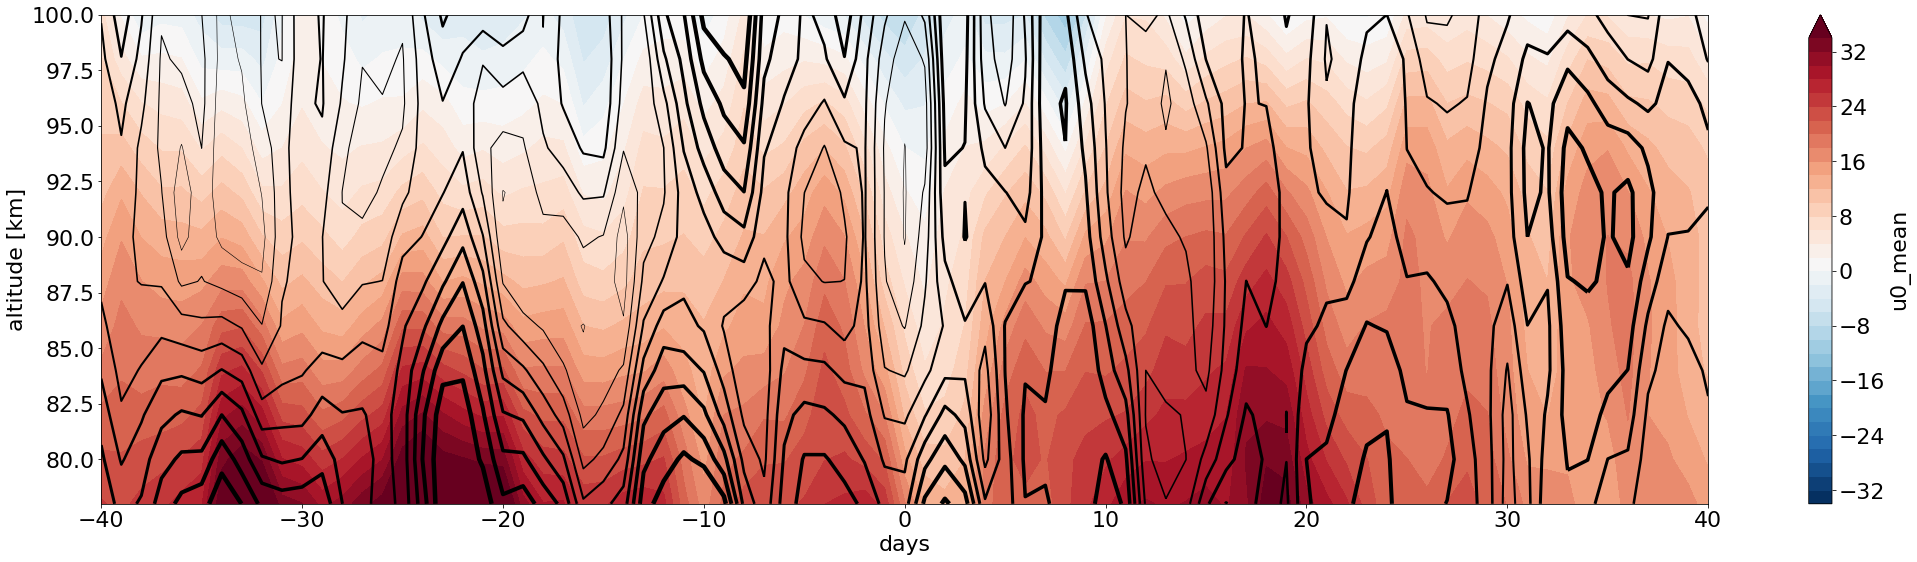

In [11]:
plotting_routine(sea_u,'u0')

#### Anomalies

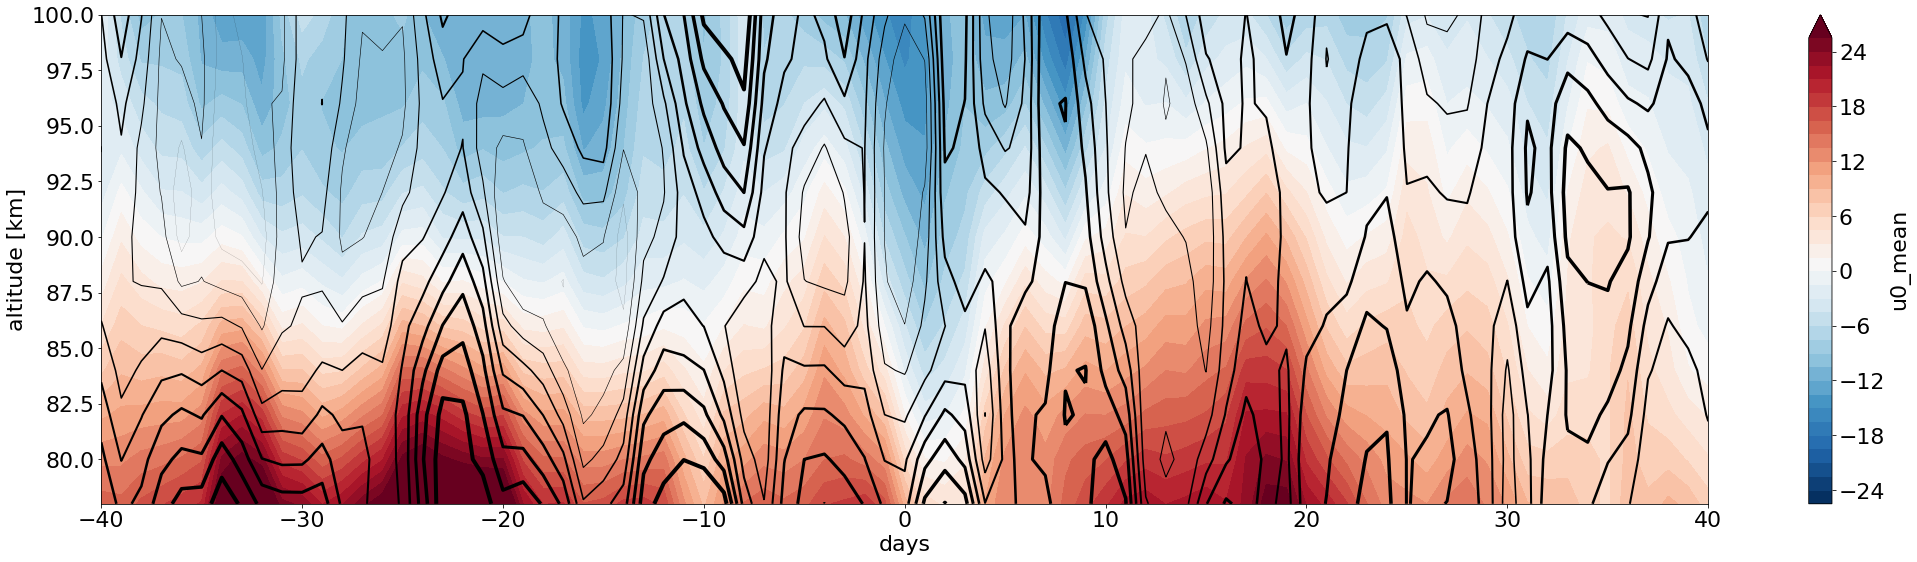

In [12]:
plotting_routine(sea_u_anomalie,'u0')

### Meridional wind component

#### Climatology

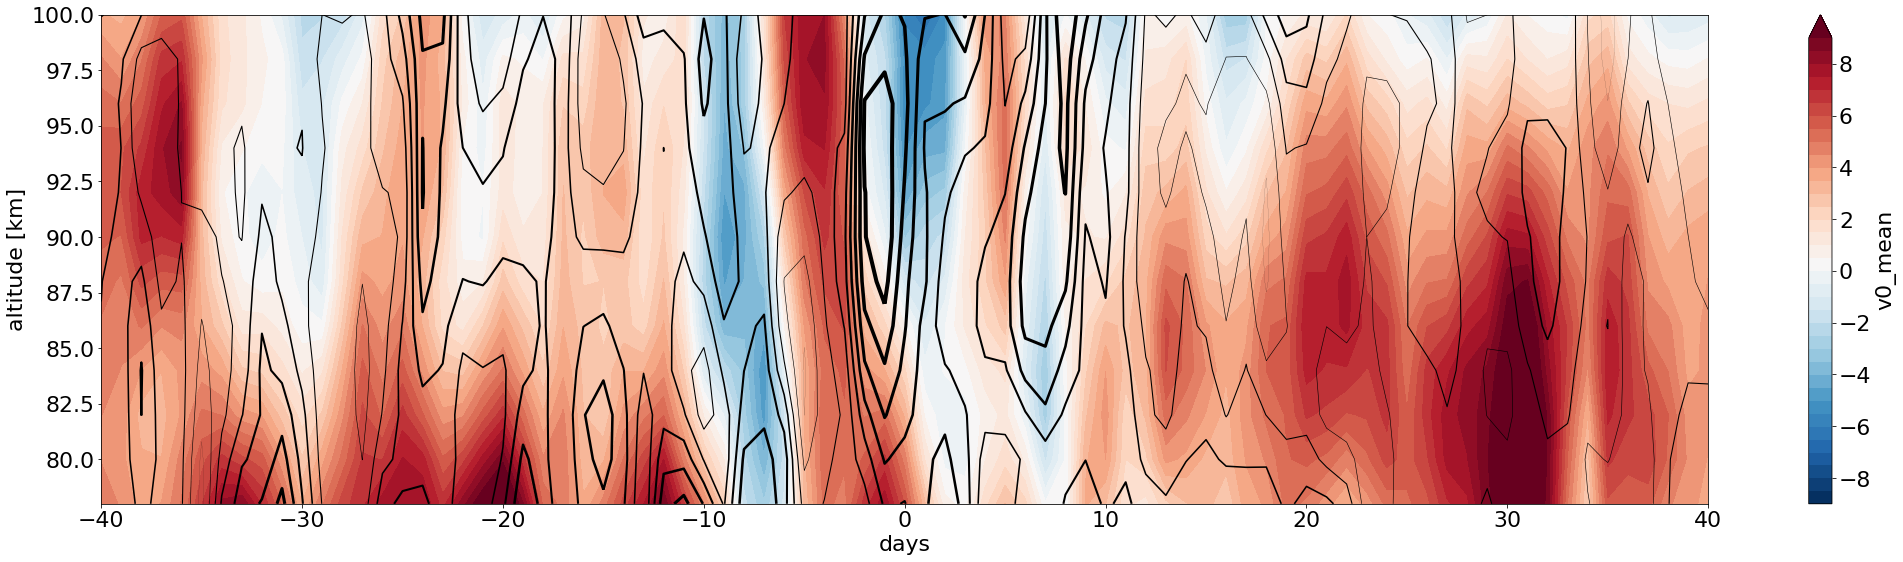

In [13]:
plotting_routine(sea_v,'v0')

#### Anomalies

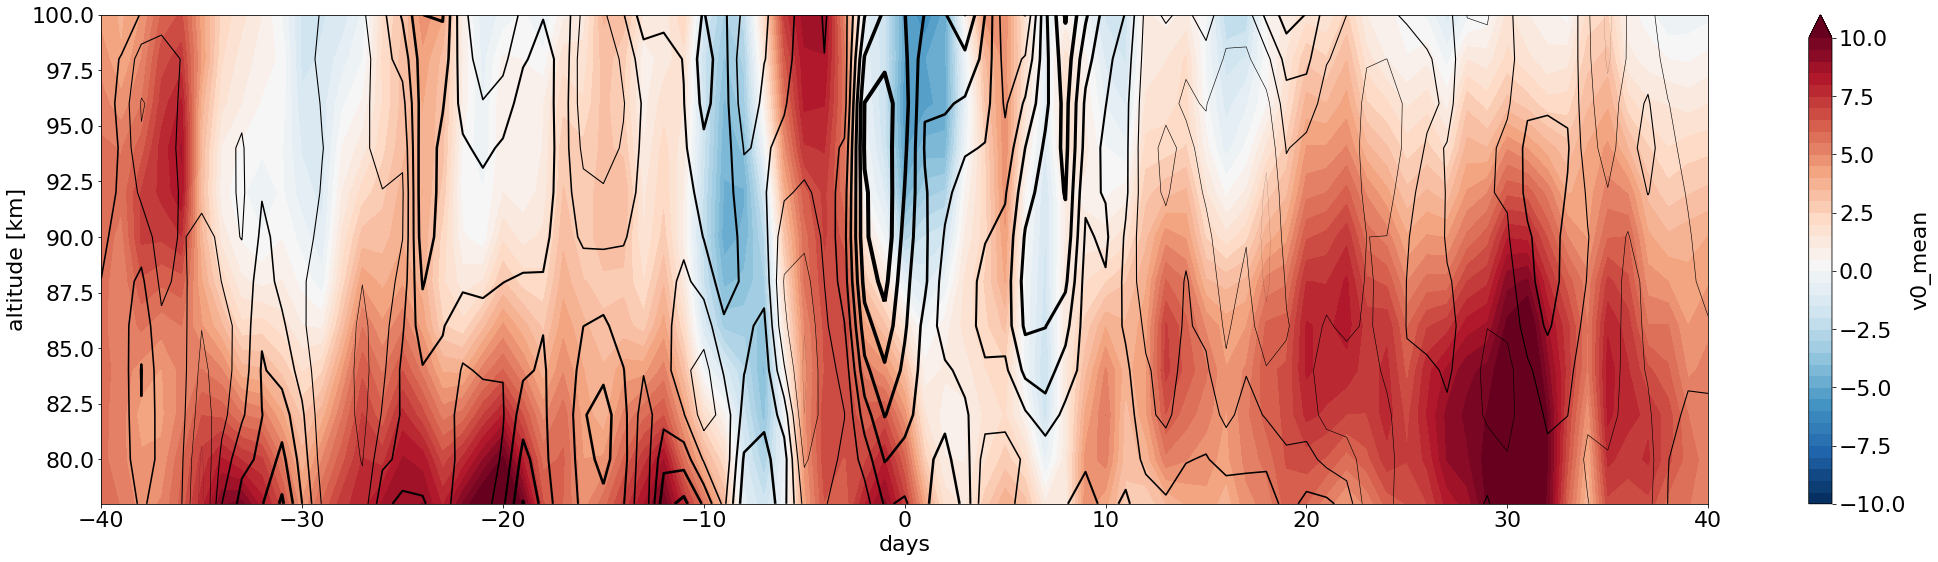

In [14]:
plotting_routine(sea_v_anomalie,'v0')

## Wave estimates

In [15]:
ds_waves = read_group('waves',station)
gw = read_var(ds_waves,'GW')
pw = read_var(ds_waves,'PW')

gw_anomalie = anomalie('day',gw)

pw_anomalie = anomalie('day',pw)

sea_gw = sea(40,station,gw)
sea_gw_anomalie = sea(40,station,gw_anomalie)

sea_pw = sea(40,station,pw)
sea_pw_anomalie = sea(40,station,pw_anomalie)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


### Gravity waves

#### Climatology

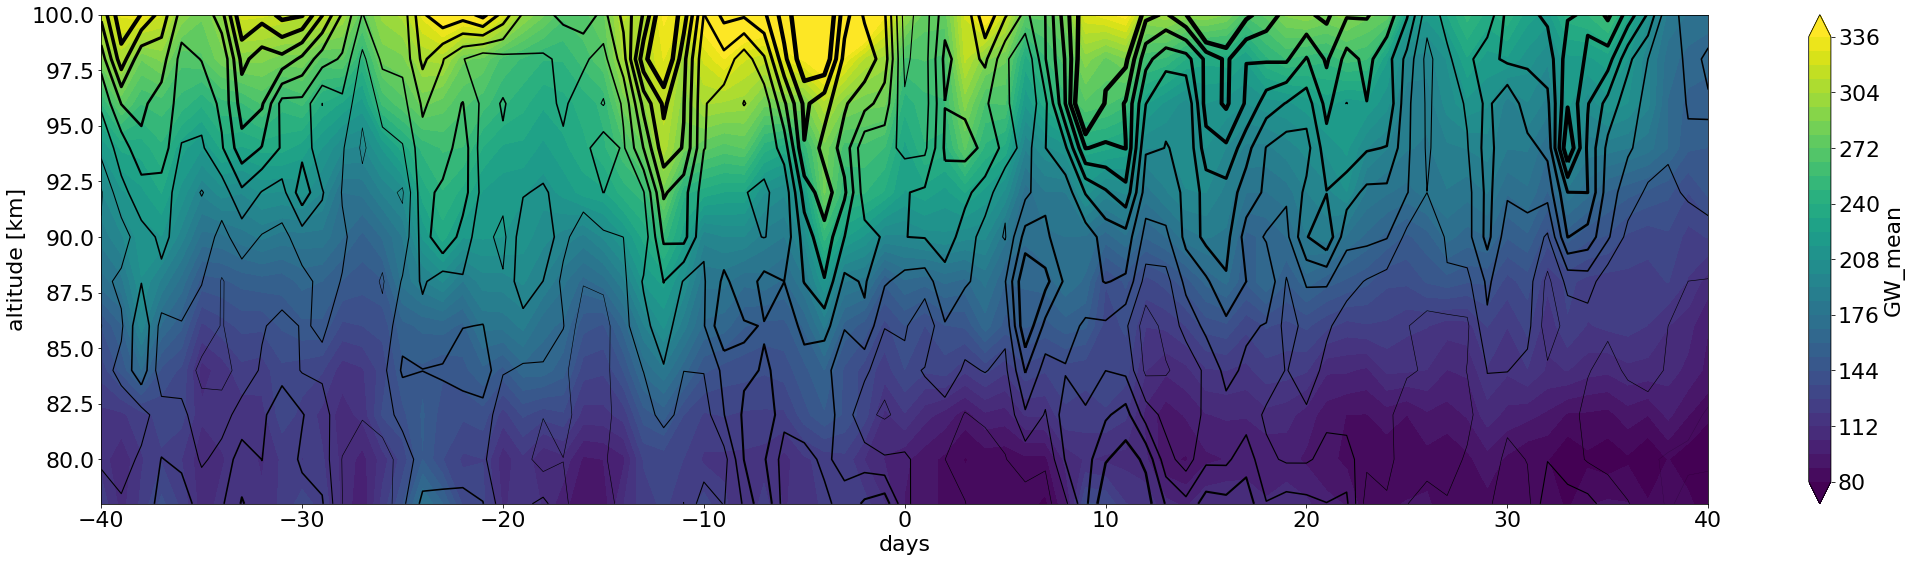

In [16]:
plotting_routine(sea_gw,'GW')

#### Anomalies

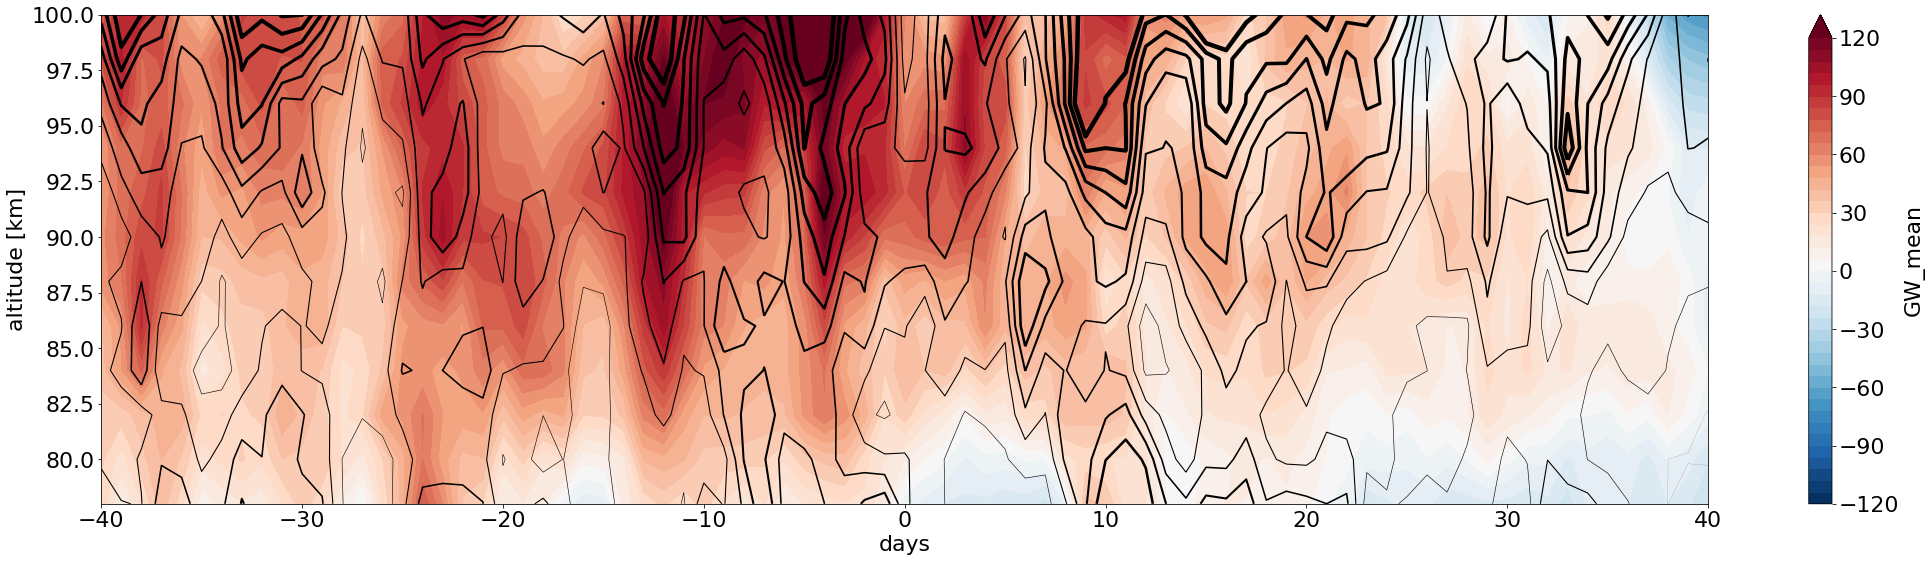

In [17]:
plotting_routine(sea_gw_anomalie,'GW')

### Planetary waves

#### Climatology

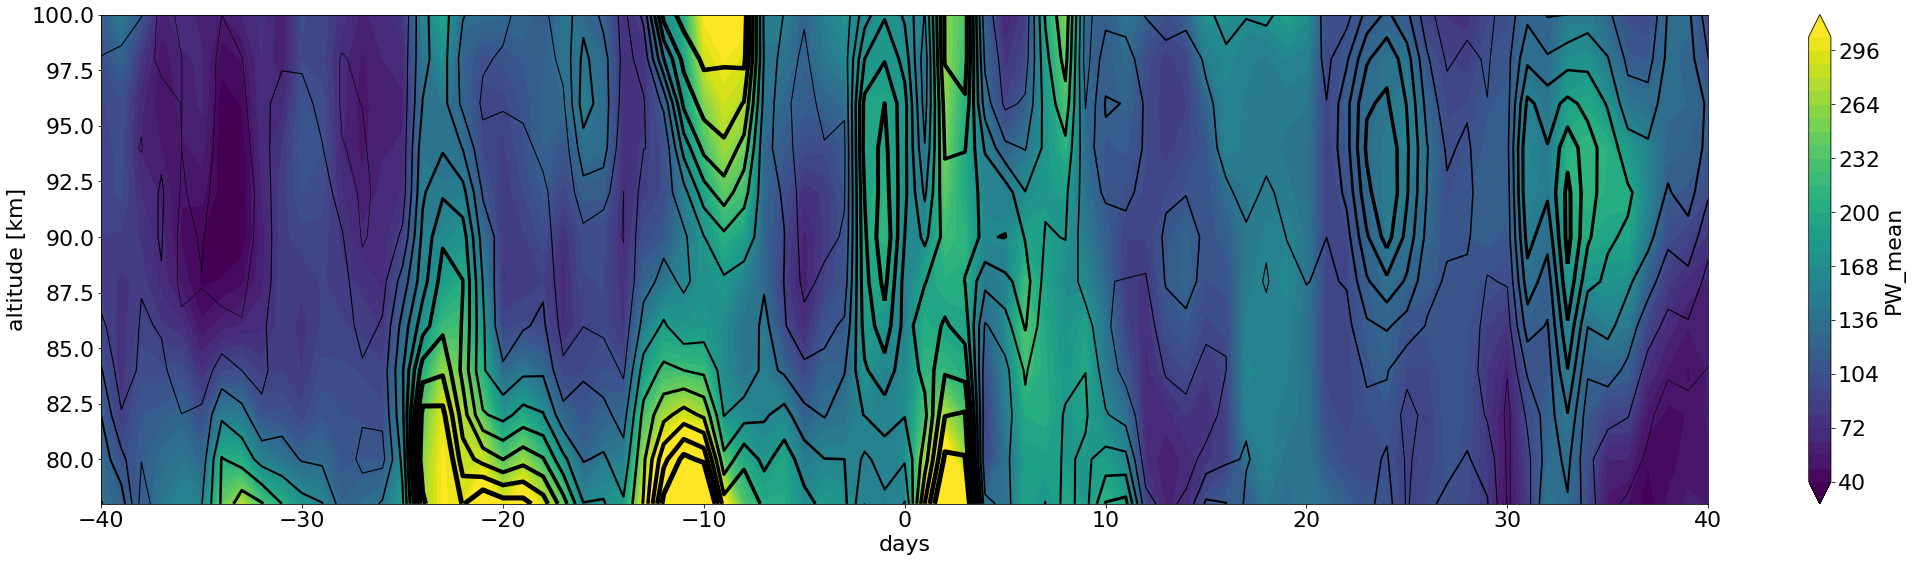

In [18]:
plotting_routine(sea_pw,'PW')

#### Anomalies

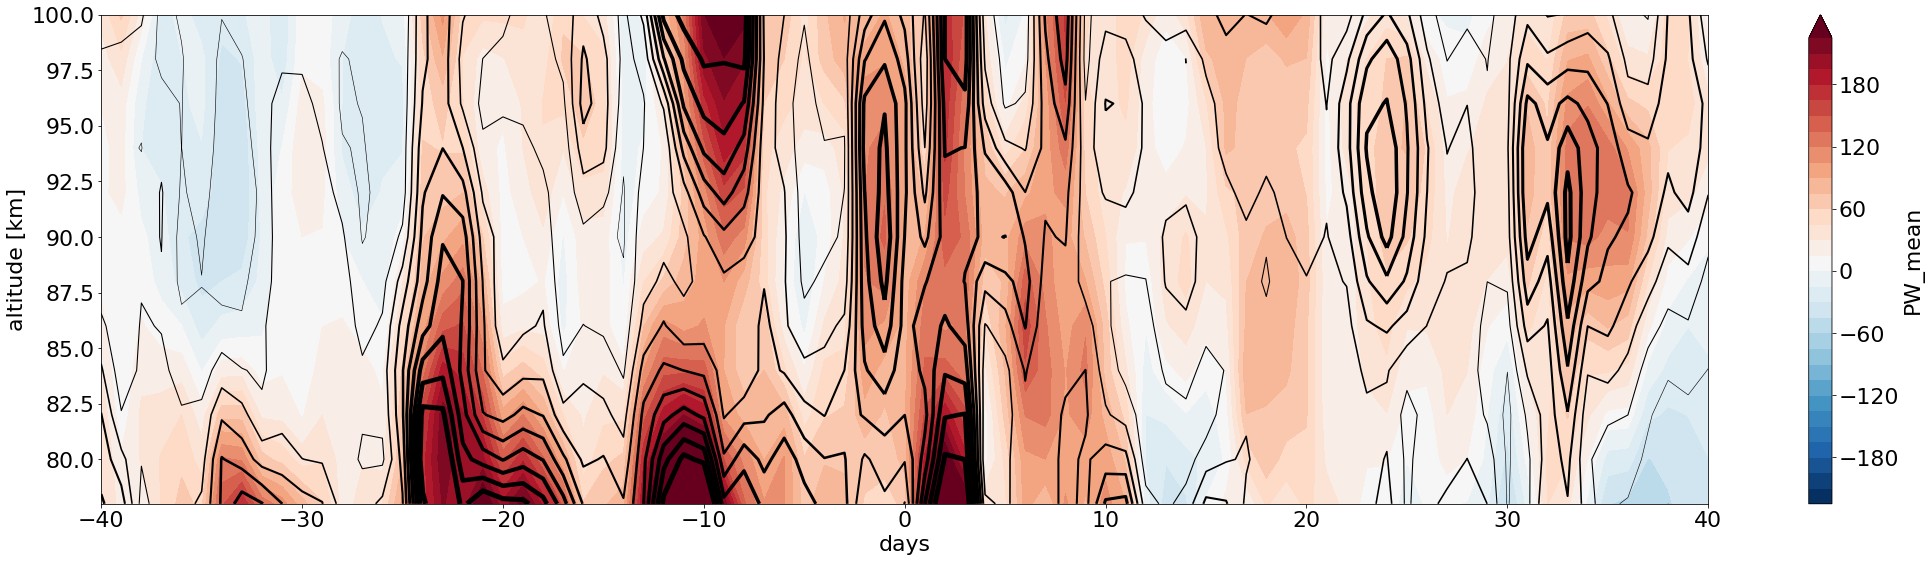

In [19]:
plotting_routine(sea_pw_anomalie,'PW')